## Step 1: Fetching Financial Data


In [30]:
import yfinance as yf
import numpy as np

# Fetching stock data for Apple Inc. from Jan 1, 2020, to Jan 1, 2021.
data = yf.download('AAPL', start='2020-01-01', end='2021-01-01')

# Extracting the Adjusted Close Prices
prices = data['Adj Close']

# Calculating daily returns as percentage change in prices
returns = prices.pct_change().dropna()  # Remove NaN values that arise from pct_change()

[*********************100%%**********************]  1 of 1 completed


## Step 2: Defining the Log-Likelihood Function for GARCH(1, 1)


$R_t = \mu + \varepsilon_t$

where

$R_t:$ Rate of return of a financial asset at time $t$, a **random variable**.

$\mu:$ Mean rate of return of a financial asset, a **constant**.

$\varepsilon_t:$ An **autoregressive** error term such that $\varepsilon_t = \sigma Z_t$, $Var(\varepsilon_t) = \sigma^2_t$ and $Z_t \sim iid N(0, 1)$

and

$\sigma^2_t = \alpha_0 + \alpha_1 \varepsilon_{t-1} + \beta_1 \sigma_{t-1}^2$

> We'll assume $\mu$ = 0

In [31]:
# def garch_log_likelihood(theta, epsilons):
#     """Calculates the log likelihood function for the list of parameters in theta
#     where theta = (alpha_0, alpha_1, beta_1)
#     This is equal to all epsilon random variables equalling to values in epsilons,
#     because epsilons are conditionally indipendent in GARCH,
#     we can assume iid normal distribution for any epsilon_i

#     Args:
#         theta (listlike): an array of 3 parameters: (alpha_0, alpha_1, beta_1)
#         epsilons (numpy array): an array of n epsilon values

#     Returns:
#         Log likelihood function for parameters alpha_0, alpha_1, beta_1
#     """
#     alpha0, alpha1, beta1 = theta

#     # Check for stationarity condition
#     if alpha1 + beta1 >= 1:
#         return -np.inf  # Return a very large negative number

#     n = len(epsilons)
#     omega = alpha0 / (1 - alpha1 - beta1)
#     variances = np.full(n, omega)

#     for t in range(1, n):
#         variances[t] = alpha0 + alpha1 * epsilons[t-1]**2 + beta1 * variances[t-1]

#         # Check for non-negative variance
#         if variances[t] <= 0:
#             return -np.inf

#     # Compute log-likelihood with numerical stability
#     logL = (-n/2) * np.log(2*np.pi) - np.sum(np.log(variances**0.5 + 1e-6)) - 0.5 * np.sum((epsilons**2)/(variances + 1e-6))
#     return logL

In [32]:
def garch_log_likelihood(theta, data):
    alpha0, alpha1, beta1 = theta
    n = len(data)
    omega = alpha0 / (1 - alpha1 - beta1)  # Ensure stationarity
    variance = np.full(n, omega)
    for t in range(1, n):
        variance[t] = alpha0 + alpha1 * data[t-1]**2 + beta1 * variance[t-1]

    # Log-likelihood of GARCH(1,1)
    return -np.sum(np.log(variance) + data**2 / variance)


## Step 3: Setting Up and Running MCMC with emcee


In [33]:
import emcee

# Initial estimates for alpha0, alpha1, and beta1
initial_estimates = np.array([0.01, 0.05, 0.9])

# Number of walkers and steps
nwalkers, nsteps = 50, 1000

# Initial positions of the walkers
pos = initial_estimates + 1e-4 * np.random.randn(nwalkers, 3)

# Setting up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, 3, garch_log_likelihood, args=[returns])

# Running the MCMC
sampler.run_mcmc(pos, nsteps, progress=True)


  0%|          | 2/1000 [00:00<01:15, 13.20it/s]

 16%|█▌        | 156/1000 [00:07<00:37, 22.75it/s]/tmp/ipykernel_12084/3631451988.py:33: RuntimeWarning: invalid value encountered in sqrt
  logL = (-n/2) * np.log(2*np.pi) - np.sum(np.log(variances**0.5 + 1e-6)) - 0.5 * np.sum((epsilons**2)/(variances + 1e-6))
 16%|█▌        | 157/1000 [00:07<00:40, 20.94it/s]


ValueError: Probability function returned NaN

**Mathematical Background:** MCMC methods, such as the one implemented in emcee, allow us to sample from the posterior distribution of the parameters 
$\alpha_0, \alpha_1, \beta_1$

The EnsembleSampler is particularly effective for exploring high-dimensional parameter spaces.

## Step 4: Analyzing the Results

In [ ]:
import matplotlib.pyplot as plt

# Extracting the samples
samples = sampler.get_chain(flat=True)
samples

array([[9.92550798e-03, 4.98497543e-02, 8.99981026e-01],
       [1.02202606e-02, 4.99775963e-02, 8.99962553e-01],
       [9.99673260e-03, 4.99203728e-02, 8.99949918e-01],
       ...,
       [6.72699932e-05, 2.04286419e-01, 7.16599824e-01],
       [7.33297680e-05, 2.00829157e-01, 7.23487660e-01],
       [6.31135187e-05, 1.35736602e-01, 7.62110460e-01]])

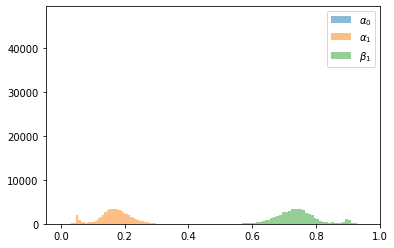

In [ ]:
# Plotting histograms of the parameter distributions
plt.hist(samples[:, 0], bins=50, alpha=0.5, label=r"$\alpha_0$")
plt.hist(samples[:, 1], bins=50, alpha=0.5, label=r"$\alpha_1$")
plt.hist(samples[:, 2], bins=50, alpha=0.5, label=r"$\beta_1$")
plt.legend()
plt.show()

**Mathematical Background:** The histograms represent the posterior distributions of the GARCH(1, 1) model parameters. These distributions provide insights into the likely values of the parameters, including their uncertainty. The peaks of the histograms indicate the most probable values for each parameter.